In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import glob
import os

!pip install rasterio
import rasterio as rio
import numpy as np

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.plot import show

In [4]:
import time

In [15]:
import dask
from dask import delayed

In [5]:
path = '/content/drive/MyDrive/PESQUISAS/ENSAIO_MUDANCAS_CLIMATICAS/DADOS/MAPBIOMAS_SEEG'

In [6]:
image_files = glob.glob(os.path.join(path, '*.tif'))
image_files

['/content/drive/MyDrive/PESQUISAS/ENSAIO_MUDANCAS_CLIMATICAS/DADOS/MAPBIOMAS_SEEG/mapbiomas-brazil-collection-90-mt-1997.tif',
 '/content/drive/MyDrive/PESQUISAS/ENSAIO_MUDANCAS_CLIMATICAS/DADOS/MAPBIOMAS_SEEG/mapbiomas-brazil-collection-90-mt-2010.tif',
 '/content/drive/MyDrive/PESQUISAS/ENSAIO_MUDANCAS_CLIMATICAS/DADOS/MAPBIOMAS_SEEG/mapbiomas-brazil-collection-90-mt-2003.tif',
 '/content/drive/MyDrive/PESQUISAS/ENSAIO_MUDANCAS_CLIMATICAS/DADOS/MAPBIOMAS_SEEG/mapbiomas-brazil-collection-90-mt-2015.tif',
 '/content/drive/MyDrive/PESQUISAS/ENSAIO_MUDANCAS_CLIMATICAS/DADOS/MAPBIOMAS_SEEG/mapbiomas-brazil-collection-90-mt-2023.tif']

In [7]:
# # Conjunto para armazenar os valores únicos de pixels
# unique_pixels = set()

# # Loop para abrir cada imagem e coletar os valores de pixels
# for image_file in image_files:
#     # Abrir a imagem raster usando rasterio
#     with rio.open(image_file) as src:
#         # Ler os dados da imagem (como uma matriz numpy)
#         pixels = src.read(1)
#         # Adicionar os valores dos pixels ao conjunto de valores únicos
#         unique_pixels.update(pixels.flatten())  # Flatten transforma em 1D e update adiciona os elementos únicos



In [8]:
legenda = pd.read_csv('/content/drive/MyDrive/PESQUISAS/ENSAIO_MUDANCAS_CLIMATICAS/DADOS/legenda_mapbiomas.csv',sep=';')
legenda

,Pixel,Classe,HEX
0,3,Formação Florestal,#1f8d49
1,4,Formação Savânica,#7dc975
2,6,Floresta Alagável,#007785
3,11,Campo Alagado e Área Pantanosa,#519799
4,12,Formação Campestre,#d6bc74
5,29,Afloramento Rochoso,#ffaa5f
6,39,Soja,#f5b3c8
7,20,Cana,#db7093
8,40,Arroz,#c71585
9,62,Algodão,#ff69b4


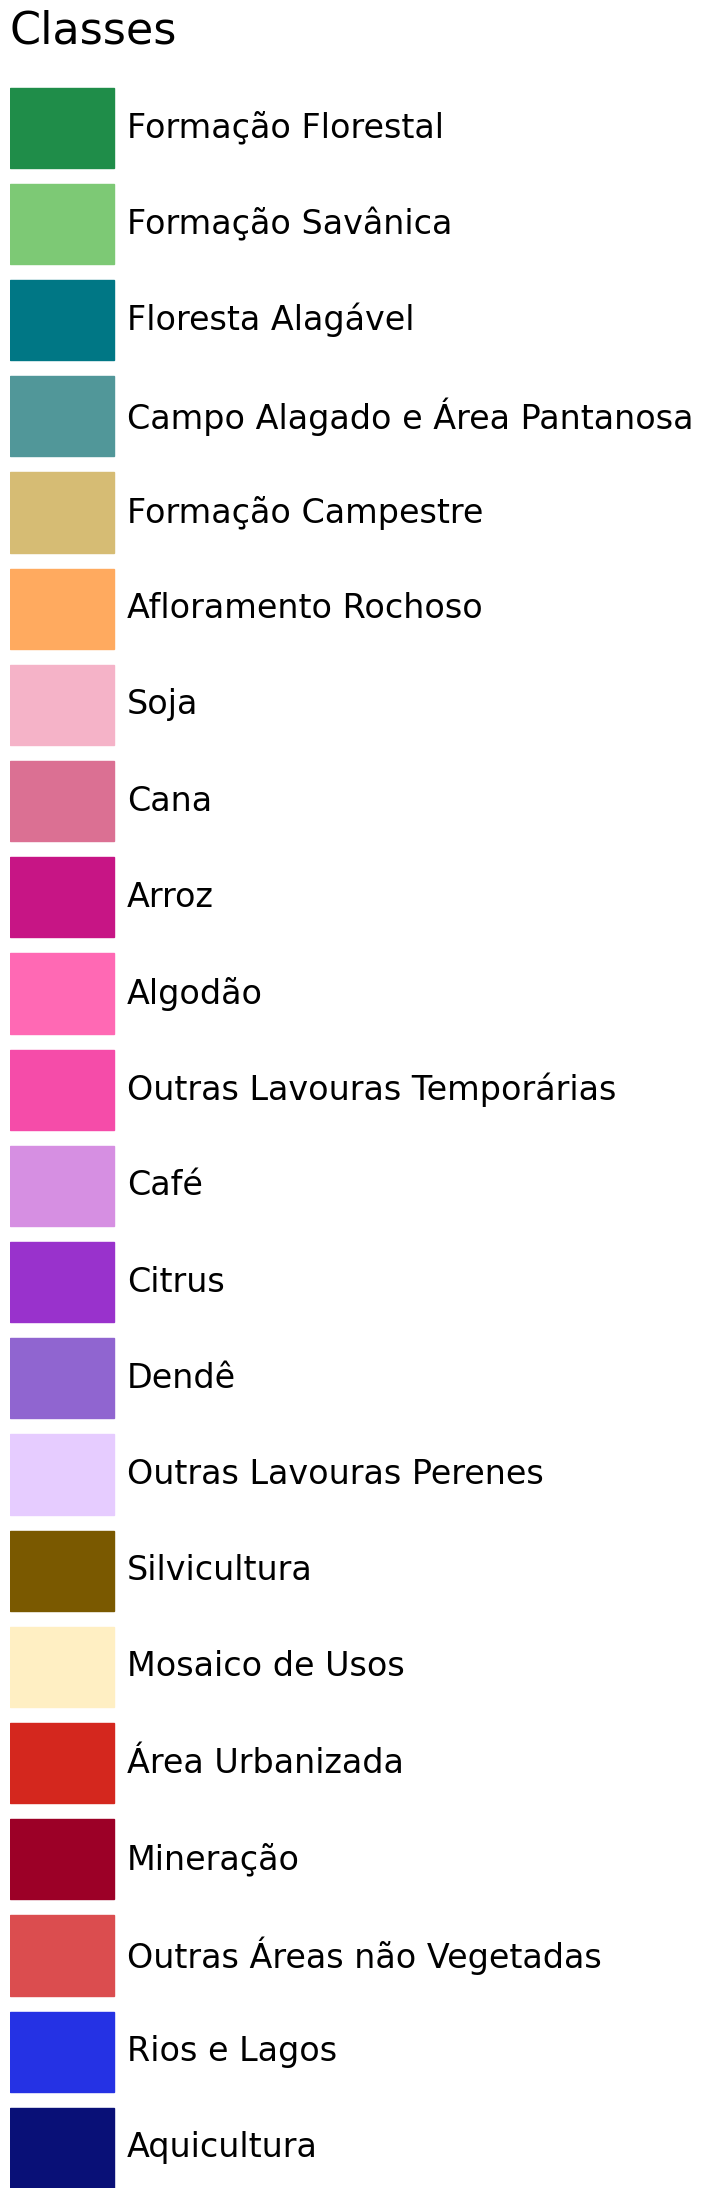

In [9]:
# Função para gerar a legenda
def gerar_legenda(legenda):
    # Reverter a ordem das linhas para exibir a legenda na ordem correta
    legenda = legenda[::-1].reset_index(drop=True)

    plt.figure(figsize=(6, len(legenda) * 1))  # Ajustar o tamanho da figura para a legenda (altura depende da quantidade de classes)

    # Criar os quadradinhos coloridos com espaçamento e largura ajustada
    for i, row in legenda.iterrows():
        # Adicionar um retângulo com a cor da classe (posição vertical alterada)
        plt.gca().add_patch(plt.Rectangle((0, i * 1.2), 0.8, 1, color=row['HEX']))  # 0.8 de largura e 1.2 de espaçamento vertical
        # Adicionar o nome da classe à direita do quadrado, com fonte maior
        plt.text(0.9, i * 1.2 + 0.5, row['Classe'], va='center', ha='left', fontsize=24)  # Fonte aumentada para 18 e posição ajustada

    # Ajustar a posição do título para alinhá-lo à esquerda
    plt.text(0, len(legenda) * 1.2 + 0.5, 'Classes', va='center', ha='left', fontsize=32)  # Alinhar à esquerda
    plt.xlim(0, 2)  # Ajustar o limite do eixo X para caber os quadradinhos e os textos
    plt.ylim(0, len(legenda) * 1.2)  # Ajustar o limite do eixo Y conforme o número de classes
    plt.axis('off')  # Desativa os eixos

    plt.tight_layout()  # Ajustar layout
    plt.show()

# Gerar a legenda
gerar_legenda(legenda)

In [14]:
# Função para gerar o mapa com base na legenda
def gerar_mapa(image_file, legenda):
    # Abrir a imagem raster usando rasterio
    with rio.open(image_file) as src:
        # Ler os dados da imagem (como uma matriz numpy)
        data = src.read(1)  # Lê a primeira banda

        # Substituir os valores de pixel pelas cores HEX associadas
        # Criar um dicionário para mapear os valores de pixel para as cores HEX
        pixel_to_color = dict(zip(legenda['Pixel'], legenda['HEX']))

        # Mapear os valores de pixels para as cores HEX
        color_map = np.array([pixel_to_color.get(pixel, '#FFFFFF') for pixel in data.flatten()])
        color_map = color_map.reshape(data.shape)

        # Criar o gráfico
        plt.figure(figsize=(10, 10))
        plt.imshow(color_map, interpolation='nearest')
        plt.title(f'Mapa Gerado para: {os.path.basename(image_file)}')
        plt.axis('off')  # Desativa os eixos
        plt.show()

In [ ]:
# Usando Dask para paralelizar o processo
inicio = time.time()

# Criar uma lista de tarefas com Dask
tasks = [delayed(gerar_mapa)(image_file, legenda) for image_file in image_files]

# Executando as tarefas de forma paralela
dask.compute(*tasks)

fim = time.time()

duracao = fim - inicio

print(f'O processamento durou {duracao} segundos.')